In [20]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import ProjectedGradientDescent
from art.metrics import empirical_robustness

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [4]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [5]:
cifar10 = tf.keras.datasets.cifar10# Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = cifar10.load_data() # Load data


# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [6]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [7]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (20000, 32, 32, 3)
Lengh of dimensions for y_train:  (20000,)
Lengh of dimensions for x_test:  (4000, 32, 32, 3)
Lengh of dimensions for y_test:  (4000,)


In [8]:
'''reshape'''
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

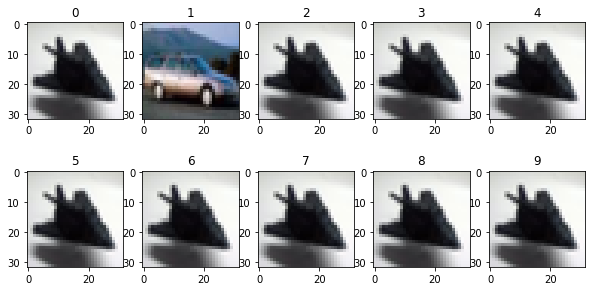

In [10]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])])
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [11]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               360500    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [12]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
625/625 [==============================] - 16s 24ms/step - loss: 0.5659 - accuracy: 0.6438 - val_loss: 0.6071 - val_accuracy: 0.7067
Epoch 2/5
625/625 [==============================] - 13s 20ms/step - loss: 0.4616 - accuracy: 0.7022 - val_loss: 0.5560 - val_accuracy: 0.7010
Epoch 3/5
625/625 [==============================] - 14s 22ms/step - loss: 0.4389 - accuracy: 0.7124 - val_loss: 0.4486 - val_accuracy: 0.7153
Epoch 4/5
625/625 [==============================] - 11s 18ms/step - loss: 0.4204 - accuracy: 0.7221 - val_loss: 0.4262 - val_accuracy: 0.7207
Epoch 5/5
625/625 [==============================] - 10s 16ms/step - loss: 0.4032 - accuracy: 0.7278 - val_loss: 0.4615 - val_accuracy: 0.7210


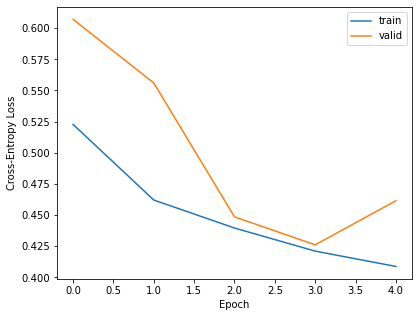

In [13]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

Test cross-entropy loss: 0.46153
Test accuracy: 0.72100


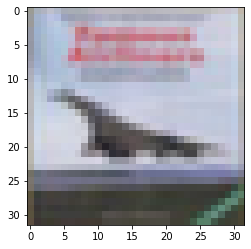

In [14]:
'''Score on original data'''
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(x_test[0])  
plt.show()

# PGD attack 

In [15]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(32,32,3),
                                   loss_object = loss_object, clip_values=(0, 1))

In [16]:
np.linalg.norm(adv_pgd_x2[1]-x_test[1])

NameError: name 'adv_pgd_x2' is not defined

In [65]:
adv_pgd_model = ProjectedGradientDescent(classifier, norm=1, eps=0.03*784, eps_step=0.5, max_iter=10, targeted=False)
adv_pgd_x1 = adv_pgd_model.generate(x=x_test)

adv_pgd_model = ProjectedGradientDescent(classifier, norm=1, eps=0.01*784, eps_step=0.5, max_iter=10, targeted=False)
adv_pgd_x2 = adv_pgd_model.generate(x=x_test)

np.linalg.norm(adv_pgd_x1[1]-adv_pgd_x[1])

0.0

In [17]:
eps_list=np.arange(0.01, 0.51, 0.05)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in ProjectedGradientDescent from ART
    also predict based on the current  adversial examples
    '''
    adv_pgd_model = ProjectedGradientDescent(classifier, norm=1, eps=eps_list[i]*784, max_iter=10,targeted=False)
    adv_pgd_x = adv_pgd_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_pgd_x)
    acc[i]=classifier._model.evaluate(adv_pgd_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 1s 7ms/step - loss: 0.7343 - accuracy: 0.6775
0.01


125/125 [==============================] - 1s 6ms/step - loss: 0.8981 - accuracy: 0.6595
0.060000000000000005


125/125 [==============================] - 1s 9ms/step - loss: 0.8981 - accuracy: 0.6595
0.11


KeyboardInterrupt: 

In [21]:
#eps_list=np.arange(0.01, 0.055, 0.005)
eps_list=np.arange(0.01, 0.51, 0.05)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in ProjectedGradientDescent from ART
    also predict based on the current  adversial examples
    '''
    adv_pgd_model = ProjectedGradientDescent(classifier, norm=2, eps=eps_list[i]*784, max_iter=10,targeted=False)
    adv_pgd_x = adv_pgd_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_pgd_x)
    acc[i]=classifier._model.evaluate(adv_pgd_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.01


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.060000000000000005


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.11


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.16000000000000003


125/125 [==============================] - 1s 7ms/step - loss: 3.6273 - accuracy: 0.3920
0.21000000000000002


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.26


125/125 [==============================] - 1s 7ms/step - loss: 3.6273 - accuracy: 0.3920
0.31000000000000005


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.36000000000000004


125/125 [==============================] - 1s 7ms/step - loss: 3.6273 - accuracy: 0.3920
0.41000000000000003


125/125 [==============================] - 1s 8ms/step - loss: 3.6273 - accuracy: 0.3920
0.46


In [22]:
# eps_list=np.arange(0.01, 0.055, 0.005)

eps_list=np.arange(0.01, 0.2, 0.02)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in ProjectedGradientDescent from ART
    also predict based on the current  adversial examples
    '''
    adv_pgd_model = ProjectedGradientDescent(classifier, norm=np.inf, eps=eps_list[i]*784, targeted=False)
    adv_pgd_x = adv_pgd_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_pgd_x)
    acc[i]=classifier._model.evaluate(adv_pgd_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 1s 7ms/step - loss: 143.3243 - accuracy: 0.2790
0.01


125/125 [==============================] - 1s 7ms/step - loss: 143.3243 - accuracy: 0.2790
0.03


125/125 [==============================] - 1s 10ms/step - loss: 143.3243 - accuracy: 0.2790
0.049999999999999996


KeyboardInterrupt: 

# ----------------------------------------------------

In [53]:
# print('class prediction for the adversarial sample:',classifier.predict(adv_fgsm_x))
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_pgd_x2, y_test)[1])

accuracy on adversarial examples:
125/125 [==============================] - 1s 5ms/step - loss: 3.2103 - accuracy: 0.4290
0.42899999022483826


Test cross-entropy loss: 0.52598
Test accuracy: 0.69725


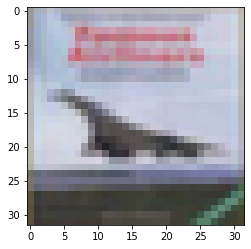

In [66]:
'''Score on adversarial examples'''
score = model.evaluate(adv_pgd_x1, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_pgd_x1[0])  
plt.show()